# Import Model

Import diatom analysis framework from scripts. Diatom model must be located in the "models" directory. Flux balance analysis and flux variability analysis are performed using Gurobi by default.

In [9]:
from scripts import Diatom

diatom = Diatom("iLB1027_lipid2.xml", model_name="P. Tricornutum")
diatom.model

Name,iLB1027_lipid
Memory address,72a265117dc0
Number of metabolites,2172
Number of reactions,4456
Number of genes,1027
Number of groups,0
Objective expression,1.0*DM_biomass_c - 1.0*DM_biomass_c_reverse_c49c1
Compartments,"cytosol, chloroplast, mitochondria, peroxisome/glyoxysome, extracellular space, thylakoid"


In [ ]:
reaction_tuple = ("EX_no3_e", "DM_biomass_c")

constraints = {
    #"EX_no3_e": (-10.0, 0),
    #"EX_photon_e": (-100, 0),
    #"CEF_h": (0, 5),
    #"EX_hco3_e": (-1000,1000)
}

diatom.set_sampling_instance(
    reaction_tuple=reaction_tuple,
    constraints=constraints,
    grid_delta=0.05,
    n_clusters=12,
    save_files=True,
    load_files=True,
)

Maximize
1.0*DM_biomass_c - 1.0*DM_biomass_c_reverse_c49c1 

Generated hash 'n_const=4_#20dde1dead159b11' for current sampling metadata:
model_filename: iLB1027_lipid2.xml
model_hash: 46fb30ca896431ee8fed56cc413c8be69f9a7cb0ef32ec45e7535d982eea12cf
constraints: {'CEF_h': [0, 5], 'EX_hco3_e': [-1000, 1000], 'EX_no3_e': [-10.0, 0], 'EX_photon_e': [-100, 0]}
n_constraints: 4
reaction_tuple: ['EX_no3_e', 'DM_biomass_c']

Data generated during analysis will not be stored.

No data will be loaded during analysis.


## Polytope Sampling



In [11]:
def polytope_pipeline(n_clusters: int):
    """Pipeline used to sample the feasible polytope projection for the given reaction tuple. 

    Parameters
    ----------
    reactions : tuple[str, str]
        Reaction tuple set for analysis. The first reaction will act as the independent axis, the second
        reaction will be set to the reaction to maximize, acting as the dependent axis.

    n_angles: int
        Number of angles specified for defining the projection polytope using ... method.

    delta: float
        Grid spacing used to generate the regular sampling grid. Corresponds to a fraction of
        the polytope bounding box size. (eg. delta=0.1 will generate steps whose lengths are 
        10% of the total length of each axis.)
       
    n_clusters: int
        Number of clusters to be generated. 

    Notes
    -----
    Smaller delta values will lead to denser sampling at higher computational cost. 

    """
    diatom.projection.project_polytope_2d()
    diatom.grid.sample_polytope()
    diatom.plot.polytope_shape() # optional
    diatom.analyze.qualitative_analysis(only_load=False)
    diatom.clustering.set_grid_clusters('hierarchical', k = n_clusters)
    diatom.plot.sampled_polytope(show_boundary=True) # optional

Number of iterations: 1


/home/chuckolate/ecosystem/scripts/diatom/plot.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


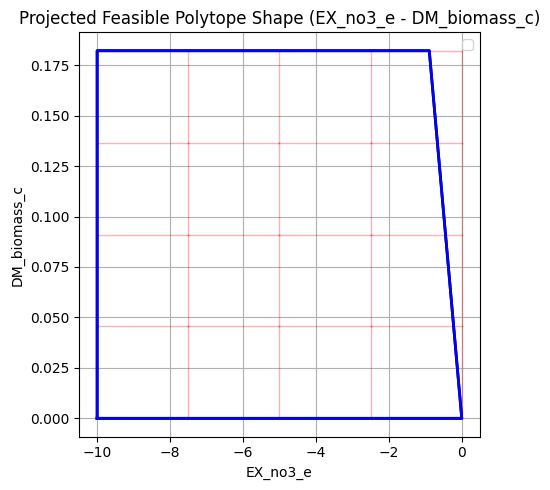

Running qualitative fva over grid feasible points...
No reactions previously selected for FVA and clustering!
Setting reactions for analysis...

Analyzing point feasibility....


100%|██████████| 28/28 [02:36<00:00,  5.58s/it]


Done!

base: (28, 1014) -> one-hot: (28, 2172)
Clustering grid points ...
Done! n_clusters: 8


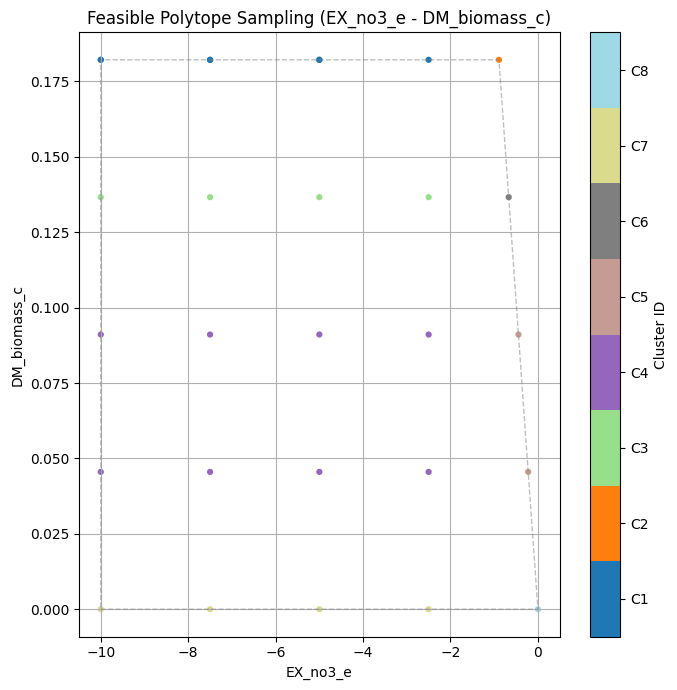

In [12]:
polytope_pipeline(n_clusters=10)


## Cluster Analysis

In [13]:
def clustering_pipeline(reaction_list, threshold=0.8, changing=False, overwrite=False):
    print("Qualitative Profiles "+"="*80+"\n")
    qualitative_profiles = diatom.clustering.get_grid_cluster_qual_profiles(threshold=threshold, changing=changing, selected_reactions=reaction_list, overwrite=overwrite)
    display(qualitative_profiles)

    print("Per Reaction Metrics "+"="*80+"\n")
    metrics_per_reaction = diatom.clustering.get_cluster_metrics_per_reaction(reaction_list, overwrite=overwrite)
    display(metrics_per_reaction)

    print("Global Metrics "+"="*80+"\n")
    global_metrics = diatom.clustering.get_cluster_global_metrics(reaction_list, overwrite=overwrite)
    display(global_metrics)

    diatom.io.merge_to_excel({"qualitative profiles": qualitative_profiles, "per reaction metrics": metrics_per_reaction, "global metrics": global_metrics})


In [14]:
df, reaction_list = diatom.clustering.reaction_scores(sort_score = True, sort_index = 5, show = True)

             votes   mean_rank
PRAIi            6    7.500000
IGPS             6    7.833333
ANPRT            6    8.333333
ADSL2r           6   10.666667
PRASCSi          6   11.833333
AIRCr            6   12.333333
GLUPRT           6   13.333333
NITR             5   11.666667
AMETt_h          5   13.000000
DXS              5   15.333333
ANTHt_h          5   16.833333
GARFT            5   16.833333
PRFGS            5   18.000000
PRAIS            5   24.500000
ATNS             5   39.333333
PRAGSr           5   39.666667
DM_no3_c         3   67.666667
DM_indole_c      2   83.666667
HMDHPS_c         2   84.666667
PPA2             2   86.833333
MTHF3ES_c        2   88.166667
PGAM_h           2  284.000000
DHFR             2  518.833333
DHFR2i           2  541.500000
TRPS3            2  870.166667
TRPS1            2  870.333333


In [15]:
REACTIONS = [
    # BIOMASS
    "DM_biomass_c",
    
    # EXCHANGE
    "EX_co2_e",
    "EX_o2_e",
    "EX_h2o_e",
    "EX_co_e", 
    "EX_no3_e",
    "EX_photon_e",
    
    # CHLOROPLAST
    "ATPS_h",
    "ATPM_h",
    "GLNA_h",
    "GLTS_h",
    "ACCOAC_h",
    "ACOATA_h",
    "NTRIR_h",
    "PSII_u",
    "FNOR_h",
    "GDR_NADP_h",
    "RUBISO_h",
    "RUBISC_h", 
    "DXPS_h",
    #"MEHLER_h",

    # MITOCHONDRIA
    "ATPS_m",
    "ATPM_m",
    "GLNA_m",
    "GLTS_m",
    "THD2_m",
    "GLUDH2_m",
    #"AGAS_m",

    # CYTOSOL
    "ATPS_c",
    "TAGAH_HDE_ARA_ARA_c",
    "ACOADAGAT_EPA_EPA_EPA_c",
    "ACOADAGAT_HDE_ARA_ARA_c",
    "NOR_c",
    "PAPA_EPA_EPA_c",
    "NITR_c",
    "HISD_c",
]

clustering_pipeline(reaction_list, overwrite=True)

Qualitative Profiles ================================================================================

cluster_dfs len: 8


,c1,c2,c3,c4,c5,c6,c7,c8
PRAIi,+,+,++,++,+,+,0+,0
IGPS,+,+,++,++,+,+,0+,0
ANPRT,+,+,++,++,+,+,0+,0
ADSL2r,+,+,++,++,+,+,0+,0
PRASCSi,+,+,++,++,+,+,0+,0
AIRCr,+,+,++,++,+,+,0+,0
GLUPRT,+,+,++,++,+,+,0+,0
NITR,+,+,++,++,+,+,0+,0
AMETt_h,+,+,++,++,+,+,0+,0
DXS,+,+,++,++,+,+,0+,0


Per Reaction Metrics ================================================================================



,reaction_id,cluster,metric,value
0,PRAIi,1,minimum,5.579392e-03
1,PRAIi,1,maximum,5.579392e-03
2,PRAIi,1,mean_range,-3.294736e-15
3,PRAIi,1,mean_midpoint,5.579392e-03
4,PRAIi,1,mean_relative_range,-5.905186e-13
...,...,...,...,...
2907,TRPS1,8,frac_zero_fixed,1.000000e+00
2908,TRPS1,8,frac_bidirectional,0.000000e+00
2909,TRPS1,8,mean_abs_flux,0.000000e+00
2910,TRPS1,8,std_range,0.000000e+00


Global Metrics ================================================================================



ValueError: Reaction 'biomass_pro_c' not found in fva_reactions

In [ ]:
"""
grid_x = [-50, -100, -150, -175]
grid_y = [0.3, 0.2, 0.1]

reaction_couplings = [
    ('EX_co2_e', 'RUBISC_h'),
    ('EX_o2_e', 'RUBISO_h'),
    ("RUBISC_h", "RUBISO_h"),
    ("EX_no3_e", "NTRIR_h")
]

for coupling in reaction_couplings:
    diatom.analyze.quan_FCA(grid_x, grid_y, coupling)
    diatom.plot.plot_qFCA()
"""

'\ngrid_x = [-50, -100, -150, -175]\ngrid_y = [0.3, 0.2, 0.1]\n\nreaction_couplings = [\n    (\'EX_co2_e\', \'RUBISC_h\'),\n    (\'EX_o2_e\', \'RUBISO_h\'),\n    ("RUBISC_h", "RUBISO_h"),\n    ("EX_no3_e", "NTRIR_h")\n]\n\nfor coupling in reaction_couplings:\n    diatom.analyze.quan_FCA(grid_x, grid_y, coupling)\n    diatom.plot.plot_qFCA()\n'